# Importa bibliotecas necessárias


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define tamanho da imagem e tamanho do lote

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2

# Carrega o dataset Cats vs Dogs do TensorFlow Datasets
  ## Faz a divisão: 70% treino, 15% validação, 15% teste


In [5]:
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

# Função de pré-processamento: redimensiona e aplica normalização da VGG16

In [6]:
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, tf.one_hot(label, NUM_CLASSES)

# Aplica o pré-processamento e organiza os dados em lotes


In [7]:
train_ds = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_ds = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Carrega o modelo VGG16 pré-treinado no ImageNet, sem a parte final (include_top=False)

In [8]:
# Isso mantém as camadas convolucionais como extratoras de características
base_model = VGG16(include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # Congela as camadas para não treinar novamente

# Cria um novo modelo com camadas densas no topo (head personalizado)

In [9]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Saída para 2 classes
])

# Compila o modelo com função de perda categórica e otimizador Adam


In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Exibe o resumo da arquitetura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Treina o modelo e Avalia o modelo nos dados de teste



In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

loss, acc = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 122s 214ms/step - accuracy: 0.9352 - loss: 2.1471 - val_accuracy: 0.9799 - val_loss: 0.0777
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 100s 197ms/step - accuracy: 0.9732 - loss: 0.1082 - val_accuracy: 0.9842 - val_loss: 0.0698
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 144s 201ms/step - accuracy: 0.9761 - loss: 0.0767 - val_accuracy: 0.9817 - val_loss: 0.0742
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 139s 196ms/step - accuracy: 0.9826 - loss: 0.0669 - val_accuracy: 0.9828 - val_loss: 0.0854
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 145s 201ms/step - accuracy: 0.9816 - loss: 0.0441 - val_accuracy: 0.9828 - val_loss: 0.0885
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9837 - loss: 0.1011
Test Loss: 0.0934
Test Accuracy: 0.9837


# Plota gráficos de loss e accuracy

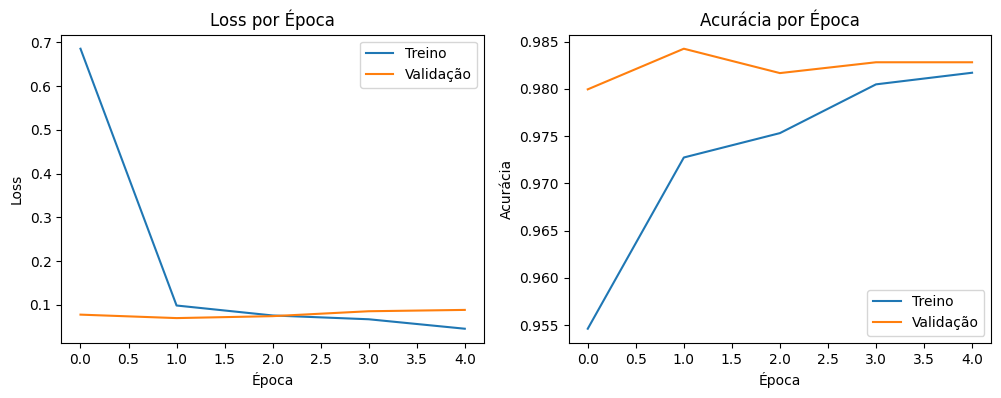

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Loss por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.title("Acurácia por Época")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()

plt.show()